In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0506 15:33:54.583512 140047217469248 file_utils.py:38] PyTorch version 1.4.0 available.
I0506 15:33:54.585278 140047217469248 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 1


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [14]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
        self.num_class = self.gpt2.config.num_labels if num_class is None else num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [15]:
TOKENIZER_PATH = './gpt_ckpt/kogpt2_news_wiki_ko_cased_818bfa919d.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='$',
                                               cls_token='@',
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [16]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 192
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 64
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [17]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [19]:
# train_data = train_data[:1000] # for test

train_data_sents = list()
train_data_labels = list()

for train_sent, train_label in zip(train_data['document'], train_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent))] + [vocab[vocab.eos_token],]
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = pad_sequences(train_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])#, padding='post')
cls_tokens = [[vocab[vocab.cls_token]]] * train_data_sents.shape[0]

train_data_sents = np.concatenate((train_data_sents, cls_tokens), axis=-1)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [20]:
cls_model = TFGPT2Classifier('./gpt_ckpt')

I0506 15:35:05.369257 140047217469248 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0506 15:35:05.370854 140047217469248 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [22]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KORtf2_gpt2_naver_movie -- Folder already exists 

Train on 134995 samples, validate on 15000 samples
Epoch 1/20
134976/134995 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8555
Epoch 00001: val_accuracy improved from -inf to 0.87973, saving model to data_out/KORtf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 606s 4ms/sample - loss: 0.3273 - accuracy: 0.8555 - val_loss: 0.2787 - val_accuracy: 0.8797
Epoch 2/20
134976/134995 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8952
Epoch 00002: val_accuracy improved from 0.87973 to 0.89147, saving model to data_out/KORtf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 590s 4ms/sample - loss: 0.2495 - accuracy: 0.8952 - val_loss: 0.2621 - val_accuracy: 0.8915
Epoch 3/20
134976/134995 [============================>.] - ETA: 0s - loss: 0.2041 - accuracy: 0.9163
Epoch 00003: val_accuracy improved from 0.89147 to 0.89573, savi

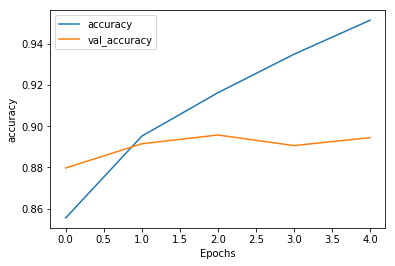

In [23]:
plot_graphs(history, 'accuracy')

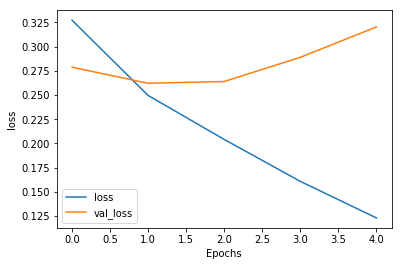

In [24]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [25]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [26]:
# test_data = test_data[:50] # for test

test_data_sents = list()
test_data_labels = list()

for test_sent, test_label in zip(test_data['document'], test_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(test_sent))] + [vocab[vocab.eos_token],]
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])#, padding='post')
cls_tokens = [[vocab[vocab.cls_token]]] * test_data_sents.shape[0]

test_data_sents = np.concatenate((test_data_sents, cls_tokens), axis=-1)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [27]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [ ]:
results = cls_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

# Quora Simliarity (ENG)

In [20]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
# MAX_LEN = 14 * 2 # Average total * 2
MAX_LEN = 65 # Average total * 2

In [21]:
# Load Train dataset
# TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.ko.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')

# train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3).dropna()

In [22]:
# train_data_xnli = train_data_xnli[:50] # for test

train_data_sent_1 = list()
train_data_sent_2 = list()

for train_sent_1, train_sent_2 in zip(train_data_xnli['sentence1'], train_data_xnli['sentence2']):
#     tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent_1))] + [vocab[vocab.eos_token],] + \
#     [vocab[vocab.sep_token],] + [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent_2))] + [vocab[vocab.eos_token]]
    train_data_sent_1.append(vocab[tokenizer(clean_text(train_sent_1))])
    train_data_sent_2.append(vocab[tokenizer(clean_text(train_sent_2))])

train_data_sent_1 = pad_sequences(train_data_sent_1, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')
train_data_sent_2 = pad_sequences(train_data_sent_2, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')

bos_tokens = np.asarray([[vocab[vocab.bos_token]]] * train_data_sent_1.shape[0], dtype=np.int64)
eos_tokens = np.asarray([[vocab[vocab.eos_token]]] * train_data_sent_1.shape[0], dtype=np.int64)
sep_tokens = np.asarray([[vocab[vocab.sep_token]]] * train_data_sent_1.shape[0], dtype=np.int64)
cls_tokens = np.asarray([[vocab[vocab.cls_token]]] * train_data_sent_1.shape[0], dtype=np.int64)

train_data_sents = np.concatenate((bos_tokens, train_data_sent_1, eos_tokens, sep_tokens, 
                                   bos_tokens, train_data_sent_2, eos_tokens, cls_tokens), axis=-1)

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [23]:
train_data_sents[0]

array([    0,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,  4027,
         259, 10027,  8201, 48373, 47459, 15170,  8151,   486,   335,
        1902,  1665,   254,   986,  2110,   123,     1, 48140,     0,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3, 15170,  8151, 23956, 10027,  8201,
       48373, 47444,  7764,  2791,   549,     1, 47810])

In [24]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_xnli["gold_label_int"] = train_data_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(train_data_sents), len(train_data_labels)))

# sents: 392662, # labels: 392662


In [14]:
sim_model = TFGPT2Classifier('./gpt_ckpt', 3)

I0502 15:14:56.874818 139715707856704 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0502 15:14:56.876290 139715707856704 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [27]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE, validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt_kornli -- Folder already exists 

Train on 314129 samples, validate on 78533 samples
Epoch 1/20
314112/314129 [============================>.] - ETA: 0s - loss: 0.7207 - accuracy: 0.6911
Epoch 00001: val_accuracy improved from -inf to 0.72329, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
314129/314129 [==============================] - 1600s 5ms/sample - loss: 0.7207 - accuracy: 0.6911 - val_loss: 0.6673 - val_accuracy: 0.7233
Epoch 2/20
314112/314129 [============================>.] - ETA: 0s - loss: 0.5954 - accuracy: 0.7551
Epoch 00002: val_accuracy improved from 0.72329 to 0.73871, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
314129/314129 [==============================] - 1594s 5ms/sample - loss: 0.5954 - accuracy: 0.7551 - val_loss: 0.6334 - val_accuracy: 0.7387
Epoch 3/20
314112/314129 [============================>.] - ETA: 0s - loss: 0.5049 - accuracy: 0.7984
Epoch 00003: val_accuracy improved from 0.73871 to 0.74327, saving model to d

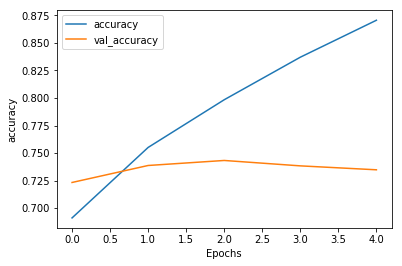

In [28]:
plot_graphs(history, 'accuracy')

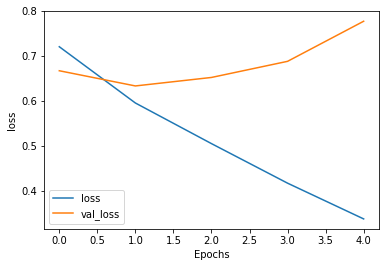

In [29]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [30]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [31]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sent_1 = list()
test_data_sent_2 = list()

for test_sent_1, test_sent_2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    test_data_sent_1.append(vocab[tokenizer(clean_text(test_sent_1))])
    test_data_sent_2.append(vocab[tokenizer(clean_text(test_sent_2))])

test_data_sent_1 = pad_sequences(test_data_sent_1, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')
test_data_sent_2 = pad_sequences(test_data_sent_2, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')

bos_tokens = np.asarray([[vocab[vocab.bos_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
eos_tokens = np.asarray([[vocab[vocab.eos_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
sep_tokens = np.asarray([[vocab[vocab.sep_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
cls_tokens = np.asarray([[vocab[vocab.cls_token]]] * test_data_sent_1.shape[0], dtype=np.int64)

test_data_sents = np.concatenate((bos_tokens, test_data_sent_1, eos_tokens, sep_tokens, 
                                   bos_tokens, test_data_sent_2, eos_tokens, cls_tokens), axis=-1)

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [32]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 5010, # labels: 5010


In [33]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 9s 2ms/sample - loss: 0.7213 - accuracy: 0.7427
test loss, test acc:  [0.7212599882346665, 0.7427146]
